In [1]:
import csv
import random
import sys
import os
sys.path.insert(0, "/home/domain/anur/work/ipynb/work/apto-docking")

from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict, Counter
from operator import itemgetter
from copy import copy

from oddt import toolkit, random_seed
from oddt.scoring import cross_validate
from oddt.scoring.functions.RFScore import rfscore
from oddt.scoring.models.regressors import randomforest, mlr, pls, neuralnetwork
from oddt.scoring.descriptors import close_contacts_descriptor
from oddt.toolkits.extras.rdkit import _sybyl_atom_type

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from rdkit.Chem.Draw import IPythonConsole 
from IPython.display import display, Image
from rdkit.Chem.rdDistGeom import ETKDG
from rdkit.Geometry import Point3D
p = ETKDG()
p.verbose = True

import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

import shap
shap.initjs()

In [2]:
def getGoodList(sys):
    pds = []
    df = pd.read_csv('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/dt3%s/results/ranking.csv' % (sys))
    names = df.LIGAND_ENTRY.values 
    df['LIGAND_ENTRY']  = [ 'dt3_' + j  for j in names ]
    pds.append(df)
    df = pd.read_csv('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/dt12%s/results/ranking.csv' % (sys))
    names = df.LIGAND_ENTRY.values 
    df['LIGAND_ENTRY']  = [ 'dt12_' + j  for j in names ]
    pds.append(df)
          
    allinone = pd.concat(pds)
    out = allinone #allinone[allinone['TOTAL_SCORE'] < 0 ]
    return out.LIGAND_ENTRY.values


def getGoodDF(sys):
    pds = []
    df = pd.read_csv('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/dt3%s/results/ranking.csv' % (sys))
    names = df.LIGAND_ENTRY.values 
    df['LIGAND_ENTRY']  = [ 'dt3_' + j  for j in names ]
    pds.append(df)
    df = pd.read_csv('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/dt12%s/results/ranking.csv' % (sys))
    names = df.LIGAND_ENTRY.values 
    df['LIGAND_ENTRY']  = [ 'dt12_' + j  for j in names ]
    pds.append(df)
        
    allinone = pd.concat(pds)
    out = allinone #allinone[allinone['TOTAL_SCORE'] < 0 ]
    return out
    
    
## For rigid protein  
#
#def gen_descriptors(ligand_file, receptor_file, ligand_format = None, receptor_format = None, goodList = []):
#    
#    if ligand_format is None:
#        ligand_format = 'sdf'
#    if receptor_format is None:
#        receptor_format = 'pdb'
#        
#    ligands = []    
#    prefix = 'dt3_'
#    
#    if 'dt12' in ligand_file:
#        prefix = 'dt12_'
#    #print(prefix)
#    for m in toolkit.readfile(ligand_format, ligand_file, lazy = False):        
#        newname = prefix + m.title
#        #print(newname)
#        if newname in goodList: 
#            #print(newname)
#            ligands.append([newname, m])
#    receptor = toolkit.readfile(receptor_format, receptor_file).__next__()
#    
#    descriptors = []
#    for i in ligands:     
#        descriptors.append([i[0], descriptor_generator.build(i[1], receptor)])
#        print("Done " + str(i[0]))
#        
#    return descriptors


# For flexible proteins

def gen_descriptors(ligand_file, receptor_file, ligand_format = None, receptor_format = None, goodList = []):

    if ligand_format is None:
        ligand_format = 'sdf'
    if receptor_format is None:
        receptor_format = 'pdb'
        
    ligands = []    
    prefix = 'dt3_'
    
    if 'dt12' in ligand_file:
        prefix = 'dt12_'
    #print(prefix)
    for m in toolkit.readfile(ligand_format, ligand_file, lazy = False):        
        newname = prefix + m.title
        #print(newname)
        if newname in goodList: 
            #print(newname)
            ligands.append([newname, m])
    
    #print('Total amount of ligands: {}'.format(len(ligands)))
    
    descriptors = []
    for n, i in enumerate(ligands):  
        receptor = toolkit.readfile(receptor_format, receptor_file[n]).__next__()
        descriptors.append([i[0], descriptor_generator.build(i[1], receptor)])
        print("Done " + str(i[0]))
        
    return descriptors


## For rigid protein
#
#def calc_descriptors(procs, pdbbind, receptor, receptor_format, ligand_format, goodList):
#    
#    MAX_PROCS = procs
#    
#    futures_dt = {}
#    executor = ProcessPoolExecutor(max_workers = MAX_PROCS)
#        
#    for pdbid in pdbbind:
#        ft = executor.submit(gen_descriptors, pdbid, receptor, ligand_format=ligand_format, receptor_format=receptor_format, goodList = goodList)
#        futures_dt[ft] = pdbid
#           
#    results = {}
#    for ft in as_completed(futures_dt):
#        args = futures_dt[ft]
#        print("Finished task for {}".format(args))
#        try:
#            result = ft.result()
#            results[args] = result
#        except Exception as exc:
#            print ("Exception occured {}".format(exc))
#            
#    descriptors = np.vstack([results[pdbid] for pdbid in pdbbind])
#    print("Finished")
#    return descriptors


# For flexible proteins

def calc_descriptors(procs, pdbbind, receptors, receptor_format, ligand_format, goodList):
    
    MAX_PROCS = procs
    
    futures_dt = {}
    executor = ProcessPoolExecutor(max_workers = MAX_PROCS)
        
    for n, pdbid in enumerate(pdbbind):
        receptor = receptors[n]
        ft = executor.submit(gen_descriptors, pdbid, receptor, ligand_format=ligand_format, receptor_format=receptor_format, goodList = goodList)
        futures_dt[ft] = pdbid
           
    results = {}
    for ft in as_completed(futures_dt):
        args = futures_dt[ft]
        print("Finished task for {}".format(args))
        try:
            result = ft.result()
            results[args] = result
        except Exception as exc:
            print ("Exception occured {}".format(exc))
            
    descriptors = np.vstack([results[pdbid] for pdbid in pdbbind])
    print("Finished")
    return descriptors


def chemdraw(smiles, include_atom_numbers = False):
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)
    if include_atom_numbers:
        display(Draw.MolToImage(mol, includeAtomNumbers = include_atom_numbers))
    else:
        display(mol)
        

# Prepare plot

def regressor_plot(X_train, X_test, Y_train, Y_test, fig_path, r_seed, suff):
    
    ax = {}
    fig, ((ax['Random Forest'], ax['Multiple Linear Regression']), 
          (ax['Partial Least Squares'], ax['Gradient Boosting'])) = plt.subplots(nrows=2, ncols=2)
    
    random_seed(r_seed)
    models = [
        (RandomForestRegressor(n_estimators=1000, n_jobs=12), "Random Forest"),
        (LinearRegression(), "Multiple Linear Regression"),
        (PLSRegression(), "Partial Least Squares"),
        (XGBRegressor(n_estimators=1000, n_jobs=12), "Gradient Boosting")
    ]
    trained_models = {}
    
    
    for model, name in models:
        print(name)
        m = model.fit(X_train, Y_train)
        trained_models[name] = m
    
        y_train_pred = m.predict(X_train)
        y_test_pred = m.predict(X_test)
    
        r_train = r2_score(y_pred=y_train_pred,
                          y_true=Y_train)
    
        r_test = r2_score(y_pred=y_test_pred, 
                          y_true=Y_test)
    
        ax[name].scatter(Y_test, y_test_pred, marker='.',  edgecolors='none', color='xkcd:azure', alpha = 0.4,
                         label=r"Test $R^2$ = %.4f" % r2_score(Y_test, y_test_pred))
    
    
        ax[name].scatter(Y_train, y_train_pred, marker='.', edgecolors='none', color='xkcd:navy', alpha = 0.4,
                         label=r"Train $R^2$ = %.4f" % r2_score(Y_train, y_train_pred))
    
        ax[name].plot(Y_train, np.polyval(np.polyfit(Y_train,y_train_pred,1), Y_train), linestyle='-', color='silver', alpha = 0.9)
        ax[name].set_title(name)
        ax[name].legend(loc=2,prop={'size':6})
        ax[name].set_xlabel("Plants Score")
        ax[name].set_ylabel("Predicted Score")
    
        
    # Save and show plot to file
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(fig_path + 'regressor_models_' + ID +  str(r_state) + '_' + str(r_seed) + suff + '.png', dpi=400)
    plt.show()
    
    return trained_models

In [3]:
ligand_atomic_nums = [6, 7, 8, 9, 15, 16, 17, 35, 53]
protein_atomic_nums = [6, 7, 8, 16]

ad4_to_atomicnum = {
        'HD': 1, 'C': 6, 'CD': 6, 'A': 6, 'N': 7, 'NA': 7, 'OA': 8, 'F': 9,
        'MG': 12, 'P': 15, 'SA': 16, 'S': 16, 'CL': 17, 'CA': 20, 'MN': 25,
        'FE': 26, 'CU': 29, 'ZN': 30, 'BR': 35, 'I': 53
    }

atomicnum_to_ad4 = defaultdict(list)
for x,y in ad4_to_atomicnum.items():
    atomicnum_to_ad4[y].append(x)
    
atoms = [#'H',
'C.3',
'C.2',
#'C.1',
'C.ar',
#'C.cat',
'N.3',
'N.2',
#'N.1',
'N.ar',
'N.am',
#'N.pl3',
'N.4',
'O.3',
'O.2',
'O.co2',
'S.3',
#'S.2',
#'S.o',
#'S.o2',
#'P.3'
        ]
protein_atoms = copy(atoms)
ligand_atoms = atoms + ['F', 'Cl', 'Br', 'C.1', 'C.cat', 'N.1', 'N.pl3', 'S.2', 'S.o', 'S.o2', 'P.3']

In [4]:
print('Protein atom types: {}'.format(protein_atoms))
print('Ligand atom types: {}'.format(ligand_atoms))

Protein atom types: ['C.3', 'C.2', 'C.ar', 'N.3', 'N.2', 'N.ar', 'N.am', 'N.4', 'O.3', 'O.2', 'O.co2', 'S.3']
Ligand atom types: ['C.3', 'C.2', 'C.ar', 'N.3', 'N.2', 'N.ar', 'N.am', 'N.4', 'O.3', 'O.2', 'O.co2', 'S.3', 'F', 'Cl', 'Br', 'C.1', 'C.cat', 'N.1', 'N.pl3', 'S.2', 'S.o', 'S.o2', 'P.3']


In [5]:
# Close contacts descriptor which tallies atoms of type X in certain cutoff (in Angstroms) from atoms of type Y

descriptor_generator = close_contacts_descriptor(mode='atom_types_sybyl', 
                                                 ligand_types=ligand_atoms, 
                                                 protein_types=protein_atoms, 
                                                 cutoff = 4.0) 

In [6]:
train_dt3_file = 'flex_prot_train_no_P_no_H_descriptors_cutoff_4_train_[24, 28, 18, 19, 29, 21, 11, 33, 34, 3, 2, 10, 9, 17, 14, 1, 26, 12, 20, 7, 4, 32, 13, 16, 25, 22, 6, 15]_test_[30, 31, 27, 0, 8, 23, 5]_r_state_17.csv'
test_dt3_file = 'flex_prot_test_no_P_no_H_descriptors_cutoff_4_train_[24, 28, 18, 19, 29, 21, 11, 33, 34, 3, 2, 10, 9, 17, 14, 1, 26, 12, 20, 7, 4, 32, 13, 16, 25, 22, 6, 15]_test_[30, 31, 27, 0, 8, 23, 5]_r_state_17.csv'

train_dt12_file = 'flex_prot_train_no_P_no_H_descriptors_cutoff_4_train_[31, 26, 21, 30, 33, 5, 19, 29, 20, 17, 27, 34, 4, 0, 11, 32, 23, 13, 8, 16, 28, 10, 6, 25, 7, 22, 12, 24]_test_[9, 2, 1, 15, 14, 18, 3]_r_state_14.csv'
test_dt12_file = 'flex_prot_test_no_P_no_H_descriptors_cutoff_4_train_[31, 26, 21, 30, 33, 5, 19, 29, 20, 17, 27, 34, 4, 0, 11, 32, 23, 13, 8, 16, 28, 10, 6, 25, 7, 22, 12, 24]_test_[9, 2, 1, 15, 14, 18, 3]_r_state_14.csv'

In [7]:
scores_dsc_train_dt3 = pd.read_csv('/home/domain/eva.smorodina/Projects/AutoDock/results/{}/scores/{}'.format('dt3', train_dt3_file), index_col=0)
scores_dsc_test_dt3 = pd.read_csv('/home/domain/eva.smorodina/Projects/AutoDock/results/{}/scores/{}'.format('dt3', test_dt3_file), index_col=0)

In [8]:
scores_dsc_train_dt12 = pd.read_csv('/home/domain/eva.smorodina/Projects/AutoDock/results/{}/scores/{}'.format('dt12', train_dt12_file), index_col=0)
scores_dsc_test_dt12 = pd.read_csv('/home/domain/eva.smorodina/Projects/AutoDock/results/{}/scores/{}'.format('dt12', test_dt12_file), index_col=0)

In [9]:
pairs = ['{}|{}'.format(lig_type, prot_type) 
         for lig_type in descriptor_generator.ligand_types
         for prot_type in descriptor_generator.protein_types]

scores_dsc_train_dt3.columns = pairs + ['binding']
scores_dsc_test_dt3.columns = pairs + ['binding']
scores_dsc_train_dt12.columns = pairs + ['binding']
scores_dsc_test_dt12.columns = pairs + ['binding']

In [10]:
fig_path = '/home/domain/eva.smorodina/Projects/AutoDock/'
table_path = '/home/domain/eva.smorodina/Projects/AutoDock/'

r_seed = 1
r_state = 1

In [11]:
ID = 'to_exp_dt3'
suff = 'dt3'

Y_train_dt3 = scores_dsc_train_dt3['binding']
X_train_dt3 = scores_dsc_train_dt3.drop(['binding'], axis=1)

Y_test_dt3 = scores_dsc_test_dt3['binding']
X_test_dt3 = scores_dsc_test_dt3.drop(['binding'], axis=1)

Processing to_exp_dt3_1
Random Forest
Multiple Linear Regression
Partial Least Squares
Gradient Boosting


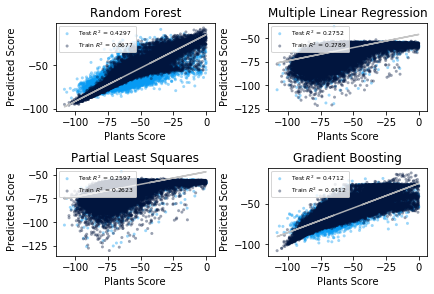

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


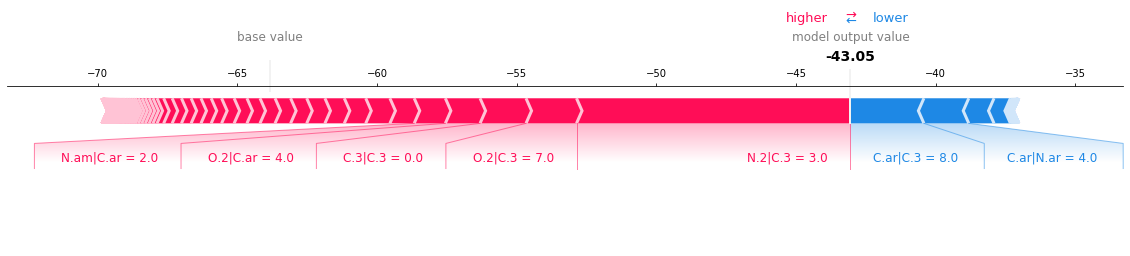

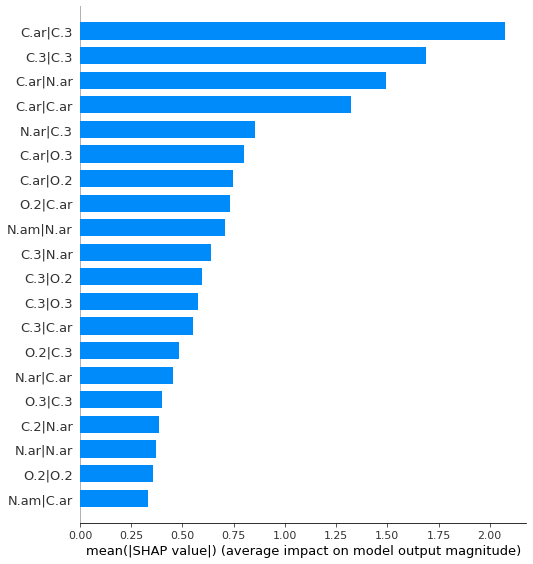

Finished to_exp_dt3_1


In [12]:
print('Processing ' + ID + '_' + str(r_seed))
trained_models_dt3 = regressor_plot(X_train_dt3, X_test_dt3, Y_train_dt3, Y_test_dt3, fig_path, r_seed, suff)

model_dt3 = trained_models_dt3['Gradient Boosting']
model_dt3 = model_dt3.get_booster()

explainer_dt3 = shap.TreeExplainer(model_dt3)
shap_values = explainer_dt3.shap_values(X_train_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer_dt3.expected_value, shap_values[0,:], X_train_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
plt.savefig(fig_path + 'one_impact_' + ID + '_' + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_train_dt3, plot_type="bar", show=False)
plt.savefig(fig_path + 'shap_feature_impact_' + ID + '_' + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
df.to_csv(table_path + 'shap_table_' + ID + '.csv',index=False)
print('Finished ' + ID + '_' + str(r_seed))

In [13]:
ID = 'to_exp_dt12'
suff = 'dt12'

Y_train_dt12 = scores_dsc_train_dt12['binding']
X_train_dt12 = scores_dsc_train_dt12.drop(['binding'], axis=1)

Y_test_dt12 = scores_dsc_test_dt12['binding']
X_test_dt12 = scores_dsc_test_dt12.drop(['binding'], axis=1)

Processing to_exp_dt12_1
Random Forest
Multiple Linear Regression
Partial Least Squares
Gradient Boosting


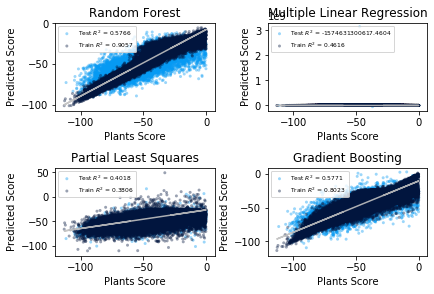

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


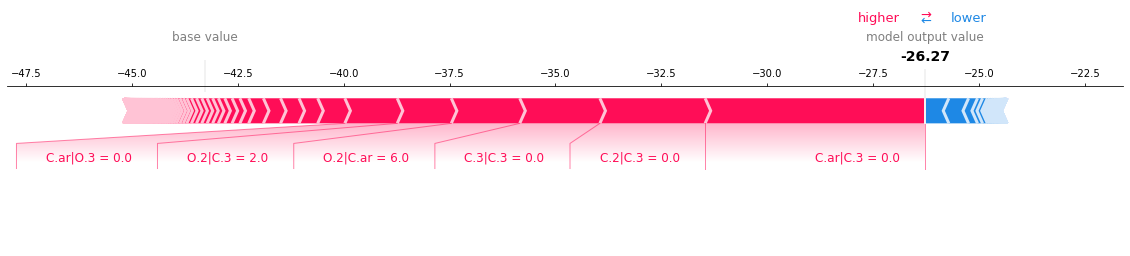

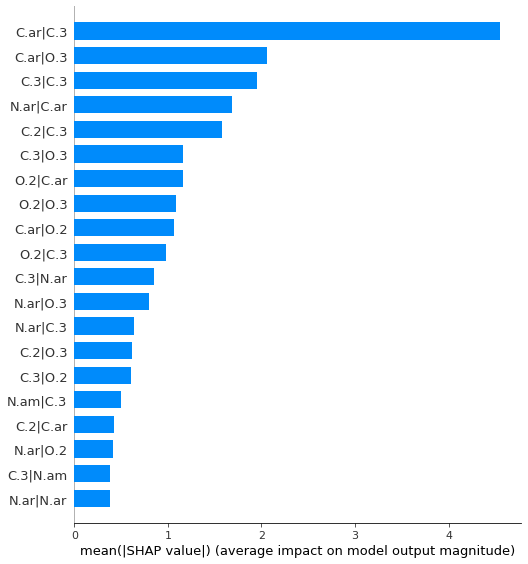

Finished to_exp_dt12_1


In [14]:
print('Processing ' + ID + '_' + str(r_seed))
trained_models_dt12 = regressor_plot(X_train_dt12, X_test_dt12, Y_train_dt12, Y_test_dt12, fig_path, r_seed, suff)

model_dt12 = trained_models_dt12['Gradient Boosting']
model_dt12 = model_dt12.get_booster()

explainer_dt12 = shap.TreeExplainer(model_dt12)
shap_values = explainer_dt12.shap_values(X_train_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer_dt12.expected_value, shap_values[0,:], X_train_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
plt.savefig(fig_path + 'one_impact_' + ID + '_' + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_train_dt12, plot_type="bar", show=False)
plt.savefig(fig_path + 'shap_feature_impact_' + ID + '_' + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
df.to_csv(table_path + 'shap_table_' + ID + '.csv',index=False)
print('Finished ' + ID + '_' + str(r_seed))

In [15]:
#train = 0.6
#test = 0.4
#print('Please enter r_state')
#r_state = int(input())
#r_seed = [1]
#ID = 'flex_prot_cutoff_4_train_{}_test_{}_random_state_{}'.format(train, test, r_state)
#
sdfList_dt3 = ('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/%s/results/docked_ligands.mol2' % ('dt3-4dii-flex'))
sdfList_dt12 = ('/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/%s/results/docked_ligands.mol2' % ('dt12-4dii-flex'))

In [16]:
file_path = '/home/domain/data/eva.smorodina/Projects/Plants/plantsdock_exp/{}-4dii-flex/results/'

dt3_receptors = [p for p in os.listdir(file_path.format('dt3')) if p.startswith('docked_proteins') and p.endswith('.mol2')]
dt12_receptors = [p for p in os.listdir(file_path.format('dt12')) if p.startswith('docked_proteins') and p.endswith('.mol2')]

dt3_receptors.remove('docked_proteins.mol2')
dt12_receptors.remove('docked_proteins.mol2')

In [17]:
len(dt3_receptors), len(dt12_receptors)

(25, 25)

In [18]:
%%time

goodList = getGoodList('-4dii-flex')
receptor_format="mol2"
ligand_format="mol2"

dt3_descriptors = []
ligands = []    
prefix = 'dt3_'

for m in toolkit.readfile(ligand_format, sdfList_dt3, lazy = False):        
    newname = prefix + m.title
    if newname in goodList: 
        ligands.append([newname, m])
        
print('Total amount of ligands: {}'.format(len(ligands)))
for n, i in enumerate(ligands): 
    receptor_file = file_path.format('dt3') + dt3_receptors[n]
    receptor = toolkit.readfile(receptor_format, receptor_file).__next__()
    dt3_descriptors.append([i[0], descriptor_generator.build(i[1], receptor)])
    print("Done " + str(i[0]))
    
print('\n')    
dt12_descriptors = []
ligands = []    
prefix = 'dt12_'

for m in toolkit.readfile(ligand_format, sdfList_dt12, lazy = False):        
    newname = prefix + m.title
    if newname in goodList: 
        ligands.append([newname, m])
        
print('Total amount of ligands: {}'.format(len(ligands)))
for n, i in enumerate(ligands): 
    receptor_file = file_path.format('dt12') + dt12_receptors[n]
    receptor = toolkit.readfile(receptor_format, receptor_file).__next__()
    dt12_descriptors.append([i[0], descriptor_generator.build(i[1], receptor)])
    print("Done " + str(i[0]))

Total amount of ligands: 25
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_01
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_02
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_03
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_04
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_05
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_01
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_02
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_03
Done dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001

In [19]:
dt3_df = pd.DataFrame([i[0] for i in np.array(dt3_descriptors)[:,1]])
dt3_df.index = np.array(dt3_descriptors)[:,0]
dt12_df = pd.DataFrame([i[0] for i in np.array(dt12_descriptors)[:,1]])
dt12_df.index = np.array(dt12_descriptors)[:,0]

In [20]:
scores = getGoodDF('-4dii-flex')
allscores = scores.set_index('LIGAND_ENTRY')

In [21]:
scores_dsc_dt3 = pd.merge(dt3_df, allscores[['TOTAL_SCORE']],left_index=True, right_index=True)
scores_dsc_dt12 = pd.merge(dt12_df, allscores[['TOTAL_SCORE']],left_index=True, right_index=True)

# Save descriptors

scores_dsc_dt3.to_csv('/home/domain/data/eva.smorodina/Projects/AutoDock/remscores/flex_dt3_descriptors_cutoff_exp.csv')
scores_dsc_dt12.to_csv('/home/domain/data/eva.smorodina/Projects/AutoDock/remscores/flex_dt12_descriptors_cutoff_exp.csv')

In [22]:
pairs = ['{}|{}'.format(lig_type, prot_type) 
         for lig_type in descriptor_generator.ligand_types
         for prot_type in descriptor_generator.protein_types]

In [23]:
scores_dsc_dt3.columns = pairs + ['binding']
scores_dsc_dt12.columns = pairs + ['binding']

In [24]:
scores_dsc_dt3

,C.3|C.3,C.3|C.2,C.3|C.ar,C.3|N.3,C.3|N.2,C.3|N.ar,C.3|N.am,C.3|N.4,C.3|O.3,C.3|O.2,...,P.3|N.3,P.3|N.2,P.3|N.ar,P.3|N.am,P.3|N.4,P.3|O.3,P.3|O.2,P.3|O.co2,P.3|S.3,binding
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_01,4,3,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,198.0880
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_02,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,201.1250
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_03,0,0,0,0,0,0,0,2,5,0,...,0,0,0,0,0,0,0,0,0,204.4000
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_04,2,1,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,204.7760
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/0.pdb_entry_00001_conf_05,2,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,211.8520
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_01,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,21.4463
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_02,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,23.5217
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_03,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,39.0298
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_04,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,46.4553
dt3_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt3-4dii-flex/1.pdb_entry_00001_conf_05,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,64.5197


In [25]:
scores_dsc_dt12

,C.3|C.3,C.3|C.2,C.3|C.ar,C.3|N.3,C.3|N.2,C.3|N.ar,C.3|N.am,C.3|N.4,C.3|O.3,C.3|O.2,...,P.3|N.3,P.3|N.2,P.3|N.ar,P.3|N.am,P.3|N.4,P.3|O.3,P.3|O.2,P.3|O.co2,P.3|S.3,binding
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/0.pdb_entry_00001_conf_01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-64.9849
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/0.pdb_entry_00001_conf_02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-58.1225
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/0.pdb_entry_00001_conf_03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-53.7982
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/0.pdb_entry_00001_conf_04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-51.5812
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/0.pdb_entry_00001_conf_05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-51.0303
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/1.pdb_entry_00001_conf_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-49.0464
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/1.pdb_entry_00001_conf_02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-44.8293
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/1.pdb_entry_00001_conf_03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-29.3992
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/1.pdb_entry_00001_conf_04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-26.0014
dt12_/home/domain/data/eva.smorodina/Projects/Plants/plantsdock3/dt12-4dii-flex/1.pdb_entry_00001_conf_05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-21.0486


In [26]:
X_dt3 = scores_dsc_train_dt3.drop(['binding'], axis=1)
X_dt12 = scores_dsc_train_dt3.drop(['binding'], axis=1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


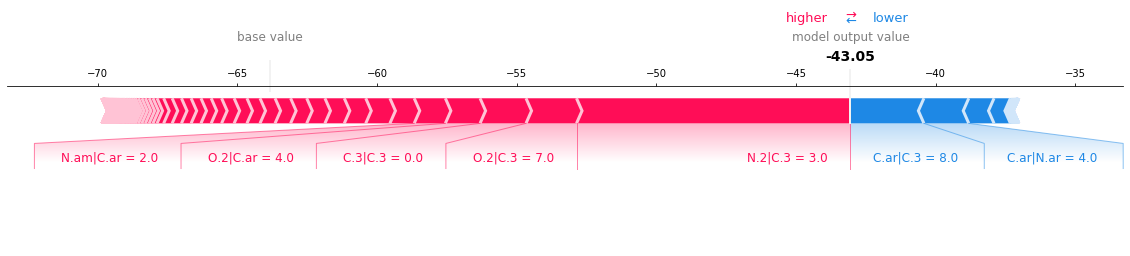

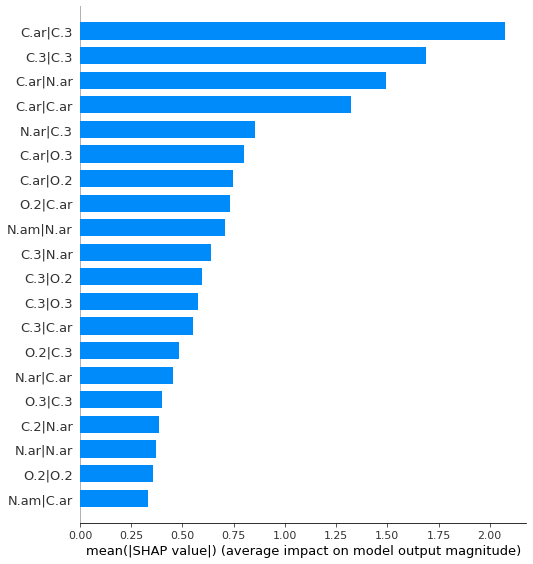

In [27]:
ID = 'exp_dt3'

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))

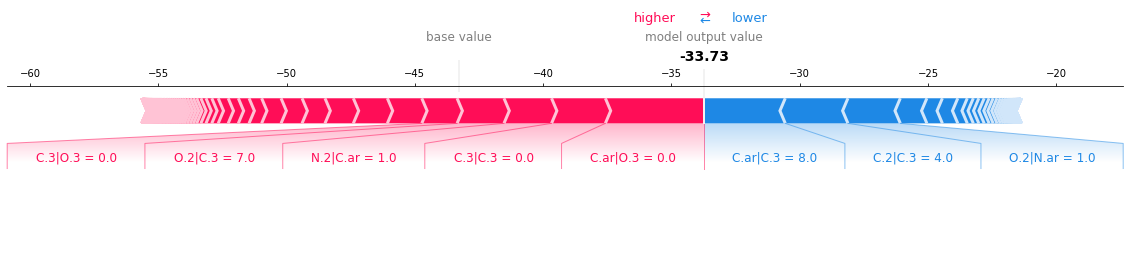

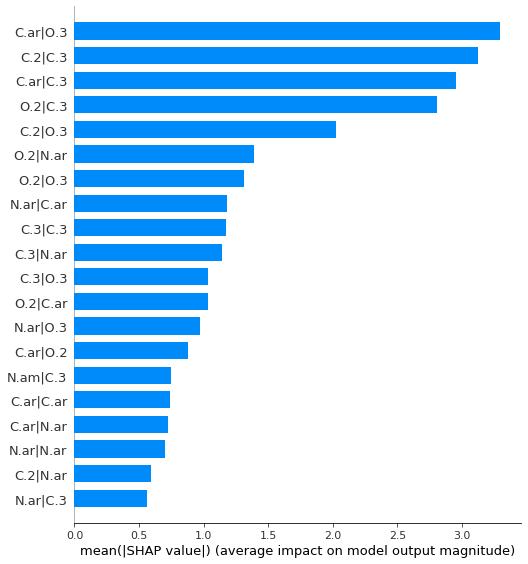

In [28]:
ID = 'exp_dt12'

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))

In [30]:
m1_dt3, m2_dt3, m3_dt3, m4_dt3, m5_dt3 = scores_dsc_dt3[:5], scores_dsc_dt3[5:10], scores_dsc_dt3[10:15], scores_dsc_dt3[15:20], scores_dsc_dt3[20:]
m1_dt12, m2_dt12, m3_dt12, m4_dt12, m5_dt12 = scores_dsc_dt12[:5], scores_dsc_dt12[5:10], scores_dsc_dt12[10:15], scores_dsc_dt12[15:20], scores_dsc_dt12[20:]

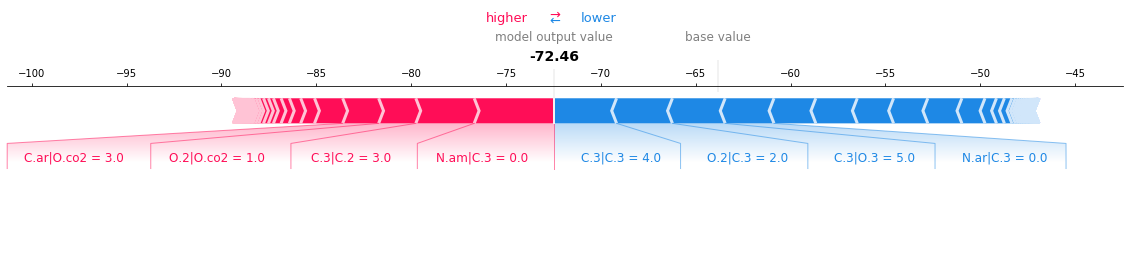

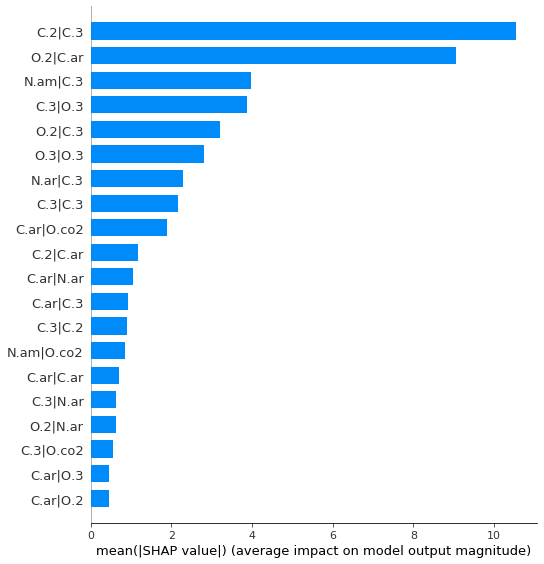

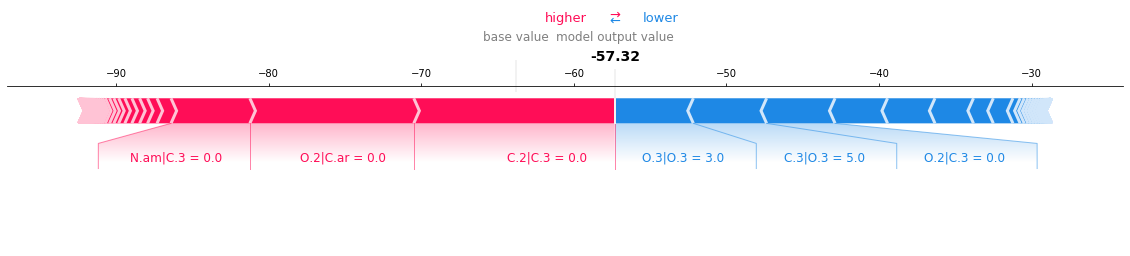

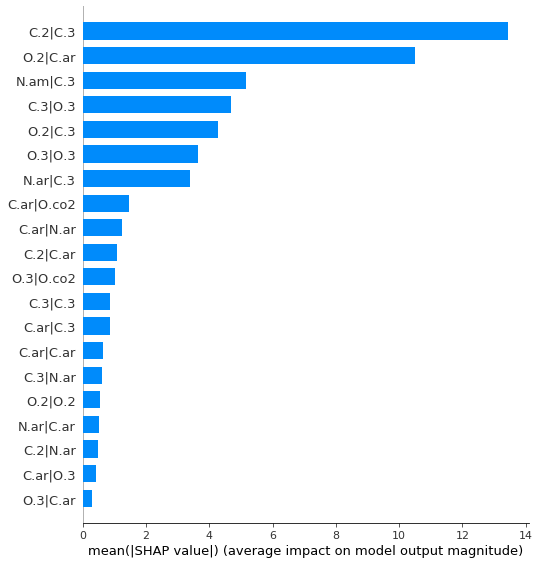

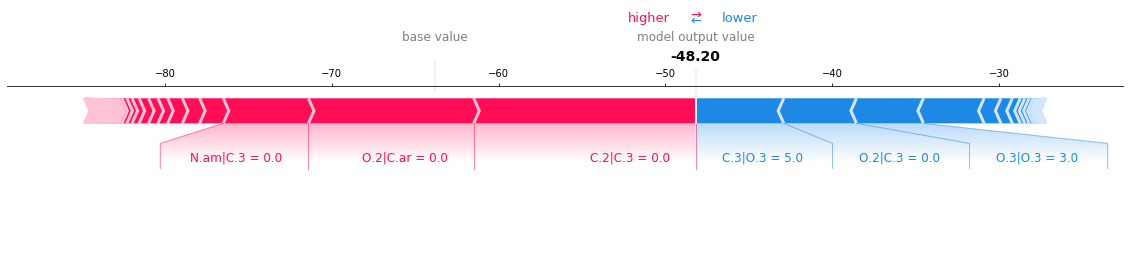

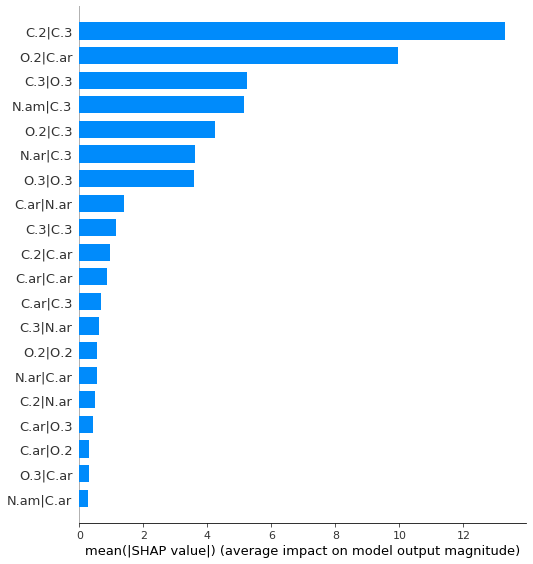

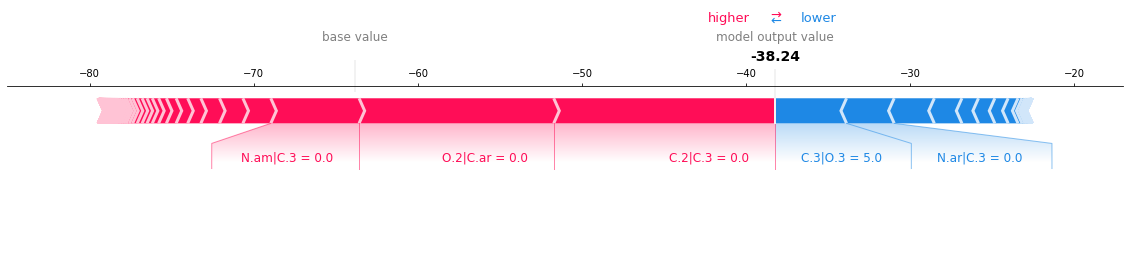

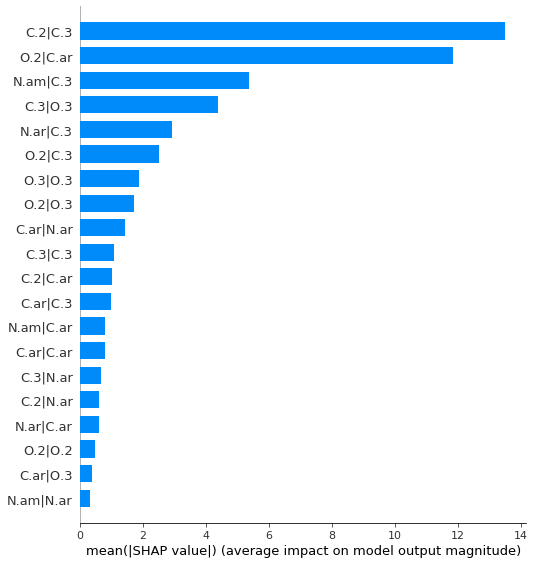

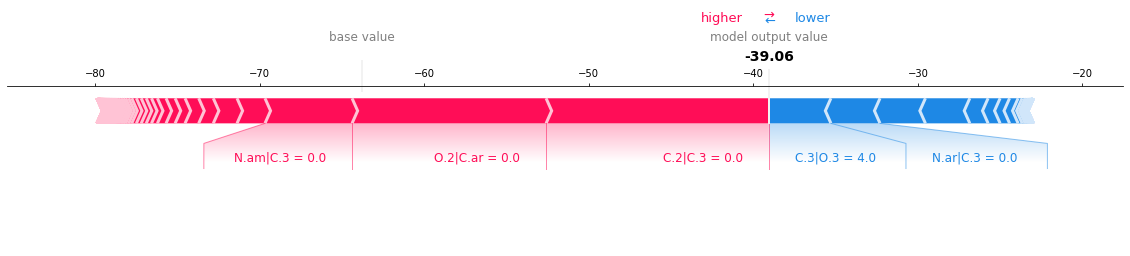

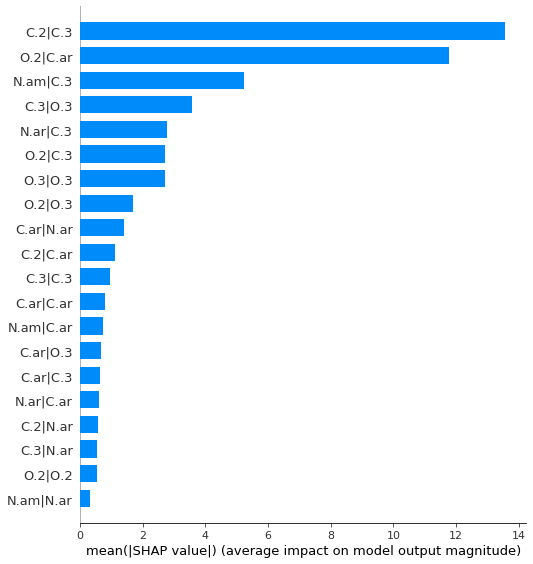

In [31]:
ID = 'exp_dt3_m1_'
X_m1_dt3 = m1_dt3.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_m1_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m1_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m1_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt3_m2_'
X_m2_dt3 = m2_dt3.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_m2_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m2_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m2_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt3_m3_'
X_m3_dt3 = m3_dt3.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_m3_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m3_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m3_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt3_m4_'
X_m4_dt3 = m4_dt3.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_m4_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m4_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m4_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))


ID = 'exp_dt3_m5_'
X_m5_dt3 = m5_dt3.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt3)
shap_values = explainer.shap_values(X_m5_dt3)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m5_dt3.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m5_dt3, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))


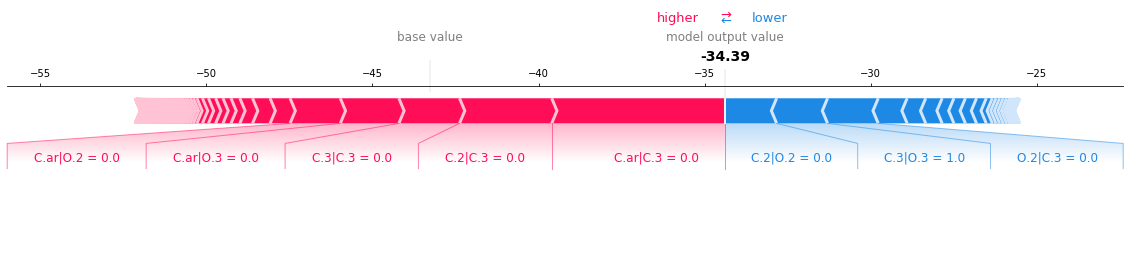

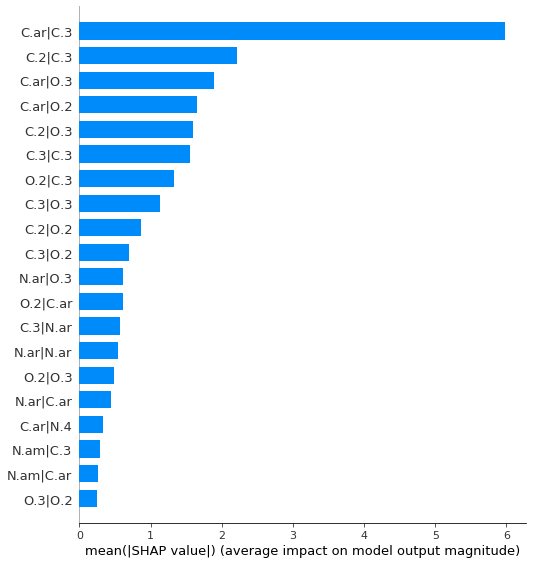

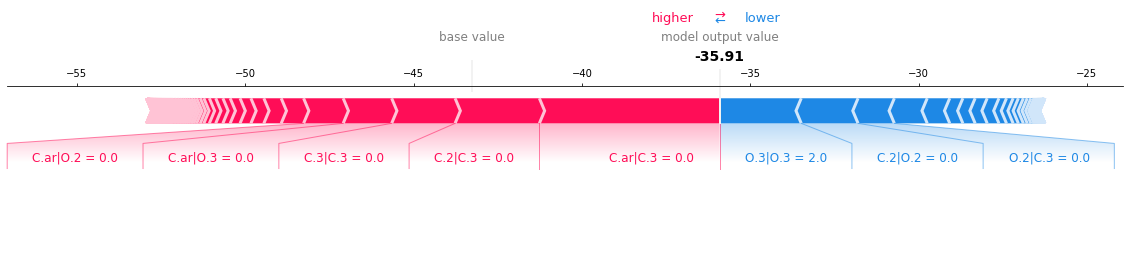

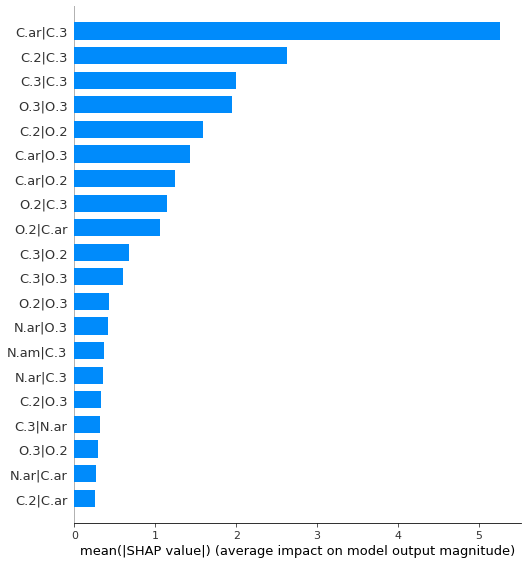

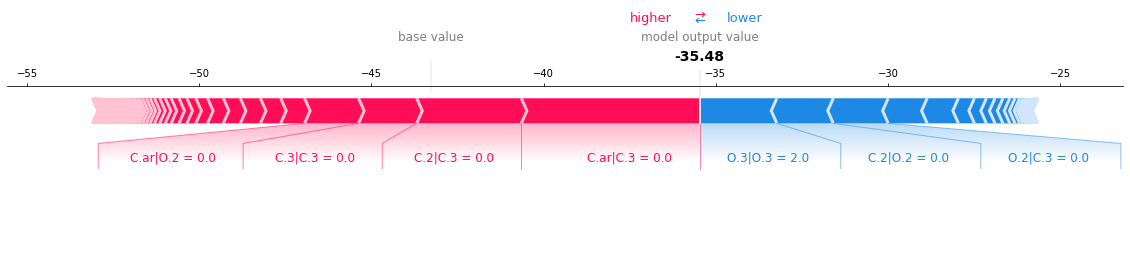

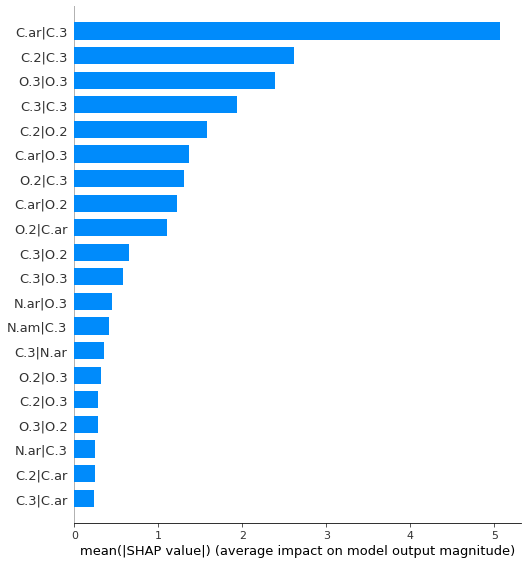

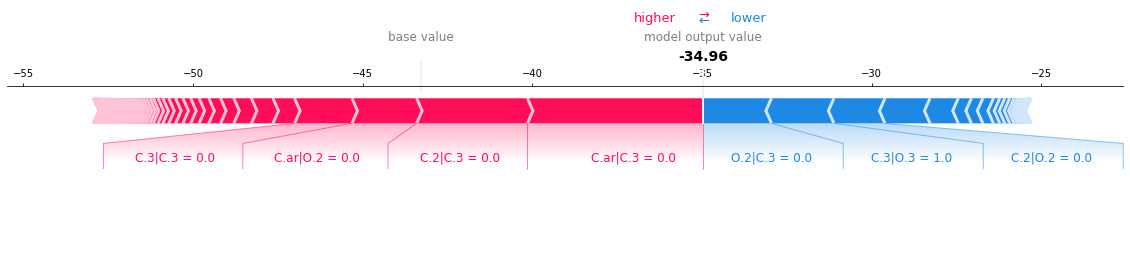

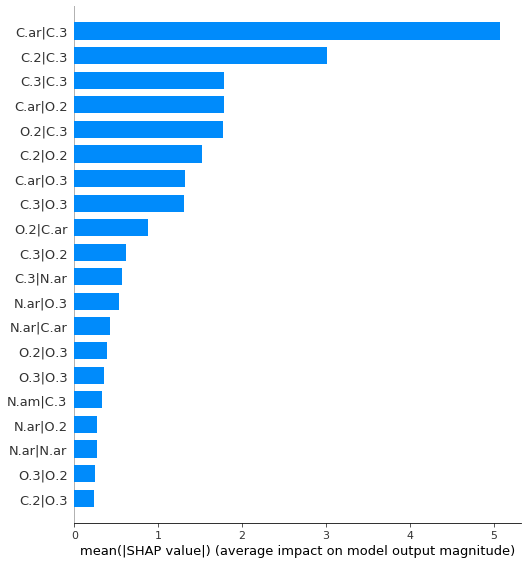

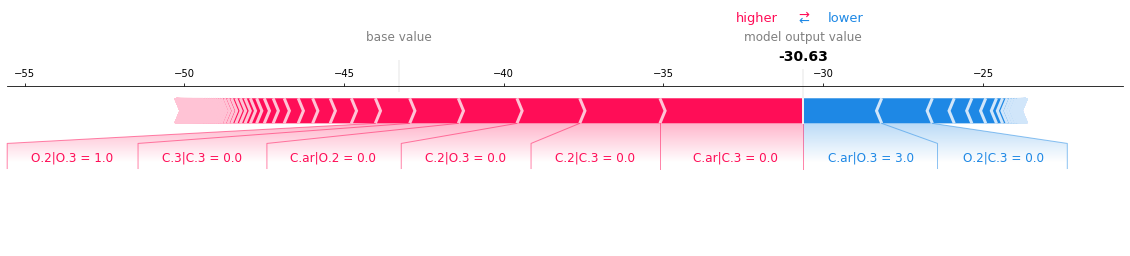

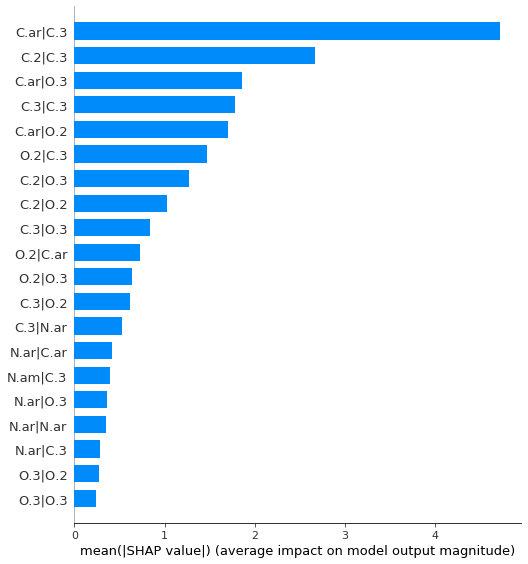

In [32]:
ID = 'exp_dt12_m1_'
X_m1_dt12 = m1_dt12.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_m1_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m1_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m1_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt12_m2_'
X_m2_dt12 = m2_dt12.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_m2_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m2_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m2_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt12_m3_'
X_m3_dt12 = m3_dt12.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_m3_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m3_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m3_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))



ID = 'exp_dt12_m4_'
X_m4_dt12 = m4_dt12.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_m4_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m4_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m4_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))


ID = 'exp_dt12_m5_'
X_m5_dt12 = m5_dt12.drop(['binding'], axis=1)

explainer = shap.TreeExplainer(model_dt12)
shap_values = explainer.shap_values(X_m5_dt12)

# Visualize the first prediction's explanation

shap.force_plot(explainer.expected_value, shap_values[0,:], X_m5_dt12.iloc[0,:], plot_cmap='PuBu', show=False, matplotlib=True)
#plt.savefig(fig_path + 'one_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

# Visualize the atom types rating

shap.summary_plot(shap_values, X_m5_dt12, plot_type="bar", show=False)
#plt.savefig(fig_path + 'shap_feature_impact_' + ID +  str(r_state) + '_' + str(i) + suff + '.png', dpi=400)
plt.show()

length = range(len(shap_values[0]))
shap_means = [np.mean(np.array(shap_values)[:,i]) for i in length]
shap_dict = dict(zip(['ID'] + pairs, [ID] + shap_means))

df = pd.DataFrame(shap_dict, index = [0])
#df.to_csv(table_path + 'shap_table_' + ID +  str(r_state) + '_' + str(i) + '.csv',index=False)
#print('Finished ' + ID +  str(r_state) + '_' + str(i))
